In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm

from graspy.plot import heatmap

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc import MGC

from simulations import rho_ER_marg, rho_sbm_marg, rho_sbm_diff_block
from utils import triu_no_diag, to_distance_mtx, identity, sbm_params, estimate_block_assignment, block_permute, sort_graph

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def to_kernel(A):
    D_vec = np.sum(A, axis=0)
    with np.errstate(divide="ignore"):
        D_root = 1 / np.sqrt(D_vec)  # this is 10x faster than ** -0.5
    D_root[np.isinf(D_root)] = 0
    D_root = np.diag(D_root)  # just change to sparse diag for sparse support
    I = np.identity(A.shape[0])
    K = I + D_root @ A @ D_root
    return K

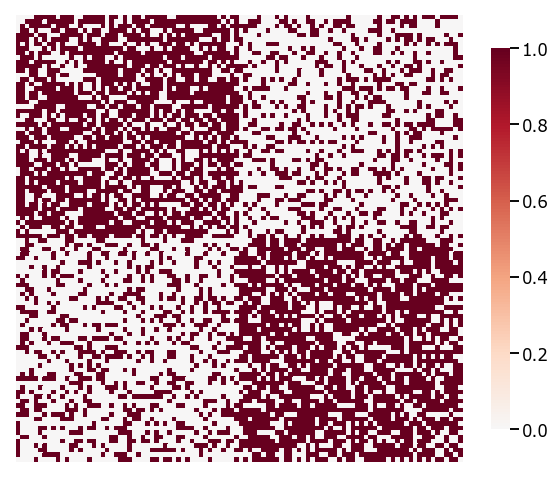

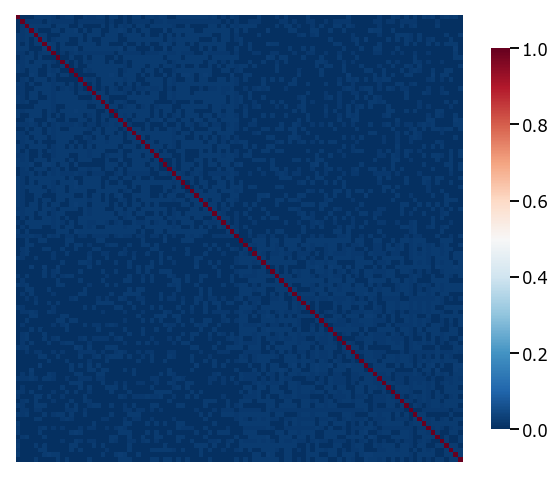

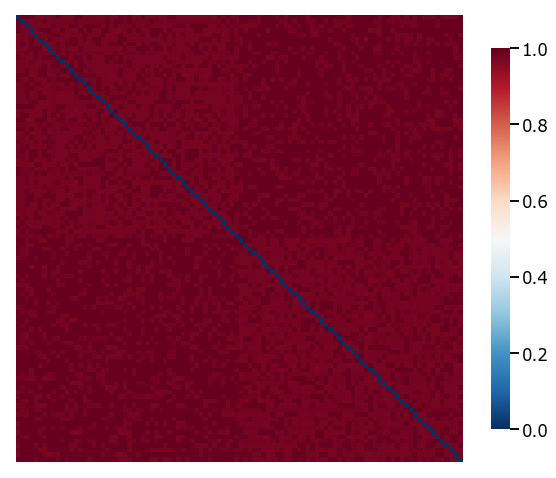

In [5]:
A, B = rho_sbm_marg(rho=0.1, k=2, AL=sbm_params(a=0.7, b=0.3), BL=sbm_params(a=0.7, b=0.3), n=100)
heatmap(A)
heatmap(to_kernel(A), center=0.5)
heatmap(to_distance_mtx(to_kernel(A)), center=0.5)

In [6]:
mgc = MGC(compute_distance_matrix=identity)
ta1, _ = mgc.test_statistic(to_distance_mtx(A), to_distance_mtx(B))
ta2, _ = mgc.test_statistic(to_distance_mtx(to_kernel(A)), to_distance_mtx(to_kernel(B)))
print(ta1)
print(ta2)

0.2613066748336377
0.2602346316168903


In [7]:
block_assignment = estimate_block_assignment(A, B)
A_null = block_permute(A, block_assignment)
B_sorted = sort_graph(B, block_assignment)
ta10, _ = mgc.test_statistic(to_distance_mtx(A_null), to_distance_mtx(B_sorted))
ta20, _ = mgc.test_statistic(to_distance_mtx(to_kernel(A_null)), to_distance_mtx(to_kernel(B_sorted)))
print(ta10)
print(ta20)

0.16143783382643342
0.17932791499839568


In [7]:
def dcorr_power(indept_test, sim_func, mc=500, alpha=0.05, given_blocks=False, blocks=None, **kwargs):
    # power for any test that builds on distance matrices
    # can use dcorr / mgc
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = sim_func(**kwargs)
        if given_blocks:
            block_assignment = blocks
        else:
            block_assignment = estimate_block_assignment(A, B)
        A_null = block_permute(A, block_assignment)
        B_sorted = sort_graph(B, block_assignment)
        
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=to_distance_mtx(to_kernel(A)), matrix_Y=to_distance_mtx(to_kernel(B)))
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=to_distance_mtx(to_kernel(A_null)), matrix_Y=to_distance_mtx(to_kernel(B_sorted)))
        
        test_stat_alt_array[i] = test_stat_alt
        test_stat_null_array[i] = test_stat_null
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [8]:
def pearson_power(indept_test, sim_func, mc=500, alpha=0.05, given_blocks=False, blocks=None, **kwargs):
    # power for any test that uses vectorized matrix as samples
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = sim_func(**kwargs)
        if given_blocks:
            block_assignment = blocks
        else:        
            block_assignment = estimate_block_assignment(A, B)
        A_null = block_permute(A, block_assignment)
        B_sorted = sort_graph(B, block_assignment)
        
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=triu_no_diag(A), matrix_Y=triu_no_diag(B))
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=triu_no_diag(A_null), matrix_Y=triu_no_diag(B_sorted))
        
        test_stat_alt_array[i] = test_stat_alt
        test_stat_null_array[i] = test_stat_null
    test_stat_null_array = np.absolute(test_stat_null_array)
    test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [ ]:
%%time
n_arr = np.array([100]) #np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0.1])
k = 2
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.7, b=0.3)
nmc = 500
test_names = ['mgc']
power_sbm = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            blocks = np.repeat(np.arange(k), n//k)
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = pearson_power(test, rho_sbm_marg, given_blocks=True, blocks=blocks,
                                           rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_sbm_marg, given_blocks=True, blocks=blocks,
                                         rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_sbm_marg, given_blocks=True, blocks=blocks,
                                         rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            power_sbm[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

In [ ]:
power_sbm

In [35]:
with open('../../results/rho_sbm_power_kernel.pkl', 'wb') as f:
    pickle.dump(power_sbm, f)

In [19]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
k = 2
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
nmc = 500
test_names = ['pearson', 'dcorr', 'mgc']
power_sbm_marg = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            blocks = np.repeat(np.arange(k), n//k)
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = pearson_power(test, rho_sbm_marg, given_blocks=True, blocks=blocks,
                                           rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_sbm_marg, given_blocks=True, blocks=blocks,
                                         rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_sbm_marg, given_blocks=True, blocks=blocks,
                                         rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            power_sbm_marg[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish pearson for rho=0.0, n=10
finish pearson for rho=0.0, n=20
finish pearson for rho=0.0, n=30
finish pearson for rho=0.0, n=40
finish pearson for rho=0.0, n=50
finish pearson for rho=0.0, n=60
finish pearson for rho=0.0, n=70
finish pearson for rho=0.0, n=80
finish pearson for rho=0.0, n=90
finish pearson for rho=0.0, n=100
finish pearson for rho=0.1, n=10
finish pearson for rho=0.1, n=20
finish pearson for rho=0.1, n=30
finish pearson for rho=0.1, n=40
finish pearson for rho=0.1, n=50
finish pearson for rho=0.1, n=60
finish pearson for rho=0.1, n=70
finish pearson for rho=0.1, n=80
finish pearson for rho=0.1, n=90
finish pearson for rho=0.1, n=100
finish dcorr for rho=0.0, n=10
finish dcorr for rho=0.0, n=20
finish dcorr for rho=0.0, n=30
finish dcorr for rho=0.0, n=40
finish dcorr for rho=0.0, n=50
finish dcorr for rho=0.0, n=60
finish dcorr for rho=0.0, n=70
finish dcorr for rho=0.0, n=80
finish dcorr for rho=0.0, n=90
finish dcorr for rho=0.0, n=100
finish dcorr for rho=0.1, n

In [25]:
power_sbm_marg

{'pearson': array([[0.068, 0.06 , 0.044, 0.05 , 0.052, 0.062, 0.054, 0.038, 0.05 ,
         0.088],
        [0.012, 0.004, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   ]]),
 'dcorr': array([[0.058, 0.036, 0.04 , 0.066, 0.056, 0.034, 0.042, 0.04 , 0.056,
         0.04 ],
        [0.132, 0.284, 0.478, 0.732, 0.898, 0.972, 0.988, 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0.058, 0.028, 0.06 , 0.064, 0.05 , 0.072, 0.066, 0.058, 0.048,
         0.056],
        [0.118, 0.288, 0.584, 0.73 , 0.892, 0.984, 0.99 , 1.   , 1.   ,
         1.   ]])}

In [36]:
with open('../../results/rho_sbm_marg_power_kernel.pkl', 'wb') as f:
    pickle.dump(power_sbm_marg, f)

In [20]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
k = 2
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
nmc = 500
test_names = ['pearson', 'dcorr', 'mgc']
power_sbm_est_block = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = pearson_power(test, rho_sbm_marg, rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_sbm_marg, rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_sbm_marg, rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            power_sbm_est_block[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish pearson for rho=0.0, n=10
finish pearson for rho=0.0, n=20
finish pearson for rho=0.0, n=30
finish pearson for rho=0.0, n=40
finish pearson for rho=0.0, n=50
finish pearson for rho=0.0, n=60
finish pearson for rho=0.0, n=70
finish pearson for rho=0.0, n=80
finish pearson for rho=0.0, n=90
finish pearson for rho=0.0, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish pearson for rho=0.1, n=10
finish pearson for rho=0.1, n=20
finish pearson for rho=0.1, n=30
finish pearson for rho=0.1, n=40
finish pearson for rho=0.1, n=50
finish pearson for rho=0.1, n=60
finish pearson for rho=0.1, n=70
finish pearson for rho=0.1, n=80
finish pearson for rho=0.1, n=90
finish pearson for rho=0.1, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish dcorr for rho=0.0, n=10
finish dcorr for rho=0.0, n=20
finish dcorr for rho=0.0, n=30
finish dcorr for rho=0.0, n=40
finish dcorr for rho=0.0, n=50
finish dcorr for rho=0.0, n=60
finish dcorr for rho=0.0, n=70
finish dcorr for rho=0.0, n=80
finish dcorr for rho=0.0, n=90
finish dcorr for rho=0.0, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish dcorr for rho=0.1, n=10
finish dcorr for rho=0.1, n=20
finish dcorr for rho=0.1, n=30
finish dcorr for rho=0.1, n=40
finish dcorr for rho=0.1, n=50
finish dcorr for rho=0.1, n=60
finish dcorr for rho=0.1, n=70
finish dcorr for rho=0.1, n=80
finish dcorr for rho=0.1, n=90
finish dcorr for rho=0.1, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish mgc for rho=0.0, n=10
finish mgc for rho=0.0, n=20
finish mgc for rho=0.0, n=30
finish mgc for rho=0.0, n=40
finish mgc for rho=0.0, n=50
finish mgc for rho=0.0, n=60
finish mgc for rho=0.0, n=70
finish mgc for rho=0.0, n=80
finish mgc for rho=0.0, n=90
finish mgc for rho=0.0, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= se

finish mgc for rho=0.1, n=10
finish mgc for rho=0.1, n=20
finish mgc for rho=0.1, n=30
finish mgc for rho=0.1, n=40
finish mgc for rho=0.1, n=50
finish mgc for rho=0.1, n=60
finish mgc for rho=0.1, n=70
finish mgc for rho=0.1, n=80
finish mgc for rho=0.1, n=90
finish mgc for rho=0.1, n=100
CPU times: user 1h 47min 15s, sys: 7min 43s, total: 1h 54min 59s
Wall time: 1h 10s


In [26]:
power_sbm_est_block

{'pearson': array([[0.044, 0.078, 0.044, 0.054, 0.07 , 0.042, 0.044, 0.052, 0.042,
         0.044],
        [0.034, 0.006, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   ]]),
 'dcorr': array([[0.02 , 0.002, 0.002, 0.038, 0.068, 0.042, 0.02 , 0.054, 0.04 ,
         0.058],
        [0.038, 0.012, 0.084, 0.74 , 0.928, 0.97 , 0.998, 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0.018, 0.   , 0.   , 0.048, 0.052, 0.064, 0.068, 0.046, 0.048,
         0.05 ],
        [0.034, 0.016, 0.078, 0.614, 0.91 , 0.96 , 0.988, 1.   , 1.   ,
         1.   ]])}

In [37]:
with open('../../results/rho_sbm_marg_est_block_power_kernel.pkl', 'wb') as f:
    pickle.dump(power_sbm_est_block, f)

In [28]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
nmc = 500
test_names = ['pearson', 'dcorr', 'mgc']
power_sbm_diff_block = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            k = [int(0.7*n), n-int(0.7*n)]
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = pearson_power(test, rho_sbm_diff_block, rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_sbm_diff_block, rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_sbm_diff_block, rho=rho, AL=P1, BL=P2, k=k, n=n, mc=nmc)
            power_sbm_diff_block[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/jxiong/Documents/Projects/graph_

finish pearson for rho=0.0, n=10
finish pearson for rho=0.0, n=20
finish pearson for rho=0.0, n=30
finish pearson for rho=0.0, n=40
finish pearson for rho=0.0, n=50
finish pearson for rho=0.0, n=60
finish pearson for rho=0.0, n=70
finish pearson for rho=0.0, n=80
finish pearson for rho=0.0, n=90
finish pearson for rho=0.0, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish pearson for rho=0.1, n=10
finish pearson for rho=0.1, n=20
finish pearson for rho=0.1, n=30
finish pearson for rho=0.1, n=40
finish pearson for rho=0.1, n=50
finish pearson for rho=0.1, n=60
finish pearson for rho=0.1, n=70
finish pearson for rho=0.1, n=80
finish pearson for rho=0.1, n=90
finish pearson for rho=0.1, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish dcorr for rho=0.0, n=10
finish dcorr for rho=0.0, n=20
finish dcorr for rho=0.0, n=30
finish dcorr for rho=0.0, n=40
finish dcorr for rho=0.0, n=50
finish dcorr for rho=0.0, n=60
finish dcorr for rho=0.0, n=70
finish dcorr for rho=0.0, n=80
finish dcorr for rho=0.0, n=90
finish dcorr for rho=0.0, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish dcorr for rho=0.1, n=10
finish dcorr for rho=0.1, n=20
finish dcorr for rho=0.1, n=30
finish dcorr for rho=0.1, n=40
finish dcorr for rho=0.1, n=50
finish dcorr for rho=0.1, n=60
finish dcorr for rho=0.1, n=70
finish dcorr for rho=0.1, n=80
finish dcorr for rho=0.1, n=90
finish dcorr for rho=0.1, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/

finish mgc for rho=0.0, n=10
finish mgc for rho=0.0, n=20
finish mgc for rho=0.0, n=30
finish mgc for rho=0.0, n=40
finish mgc for rho=0.0, n=50
finish mgc for rho=0.0, n=60
finish mgc for rho=0.0, n=70
finish mgc for rho=0.0, n=80
finish mgc for rho=0.0, n=90
finish mgc for rho=0.0, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= se

finish mgc for rho=0.1, n=10
finish mgc for rho=0.1, n=20
finish mgc for rho=0.1, n=30
finish mgc for rho=0.1, n=40
finish mgc for rho=0.1, n=50
finish mgc for rho=0.1, n=60
finish mgc for rho=0.1, n=70
finish mgc for rho=0.1, n=80
finish mgc for rho=0.1, n=90
finish mgc for rho=0.1, n=100
CPU times: user 1h 45min 42s, sys: 7min 32s, total: 1h 53min 14s
Wall time: 56min 52s


In [33]:
power_sbm_diff_block

{'pearson': array([[0.076, 0.106, 0.042, 0.052, 0.042, 0.048, 0.048, 0.064, 0.022,
         0.056],
        [0.048, 0.006, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   ]]),
 'dcorr': array([[0.024, 0.   , 0.   , 0.004, 0.046, 0.046, 0.064, 0.048, 0.054,
         0.02 ],
        [0.04 , 0.054, 0.09 , 0.612, 0.948, 0.978, 0.996, 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0.026, 0.004, 0.   , 0.02 , 0.058, 0.048, 0.054, 0.054, 0.032,
         0.06 ],
        [0.018, 0.036, 0.068, 0.58 , 0.908, 0.99 , 0.996, 0.998, 1.   ,
         1.   ]])}

In [38]:
with open('../../results/rho_sbm_diff_block_power_kernel.pkl', 'wb') as f:
    pickle.dump(power_sbm_diff_block, f)

In [29]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
p = 0.5
q = 0.5
nmc = 500
k = 1
test_names = ['pearson', 'dcorr', 'mgc']
power_er = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            blocks = np.repeat(np.arange(k), n//k)
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = pearson_power(test, rho_ER_marg, given_blocks=True, blocks=blocks,
                                           rho=rho, p=p, q=q, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_ER_marg, given_blocks=True, blocks=blocks,
                                           rho=rho, p=p, q=q, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_ER_marg, given_blocks=True, blocks=blocks,
                                           rho=rho, p=p, q=q, n=n, mc=nmc)
            power_er[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish pearson for rho=0.0, n=10
finish pearson for rho=0.0, n=20
finish pearson for rho=0.0, n=30
finish pearson for rho=0.0, n=40
finish pearson for rho=0.0, n=50
finish pearson for rho=0.0, n=60
finish pearson for rho=0.0, n=70
finish pearson for rho=0.0, n=80
finish pearson for rho=0.0, n=90
finish pearson for rho=0.0, n=100
finish pearson for rho=0.1, n=10
finish pearson for rho=0.1, n=20
finish pearson for rho=0.1, n=30
finish pearson for rho=0.1, n=40
finish pearson for rho=0.1, n=50
finish pearson for rho=0.1, n=60
finish pearson for rho=0.1, n=70
finish pearson for rho=0.1, n=80
finish pearson for rho=0.1, n=90
finish pearson for rho=0.1, n=100
finish dcorr for rho=0.0, n=10
finish dcorr for rho=0.0, n=20
finish dcorr for rho=0.0, n=30
finish dcorr for rho=0.0, n=40
finish dcorr for rho=0.0, n=50
finish dcorr for rho=0.0, n=60
finish dcorr for rho=0.0, n=70
finish dcorr for rho=0.0, n=80
finish dcorr for rho=0.0, n=90
finish dcorr for rho=0.0, n=100
finish dcorr for rho=0.1, n

In [32]:
power_er

{'pearson': array([[0.068, 0.05 , 0.04 , 0.054, 0.056, 0.038, 0.064, 0.076, 0.028,
         0.042],
        [0.112, 0.196, 0.498, 0.772, 0.948, 0.988, 0.998, 1.   , 1.   ,
         1.   ]]),
 'dcorr': array([[0.072, 0.074, 0.054, 0.044, 0.034, 0.054, 0.026, 0.036, 0.038,
         0.042],
        [0.128, 0.352, 0.708, 0.814, 0.956, 0.992, 0.998, 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0.062, 0.03 , 0.022, 0.044, 0.058, 0.052, 0.048, 0.056, 0.024,
         0.046],
        [0.188, 0.362, 0.658, 0.462, 0.408, 0.256, 0.202, 0.25 , 0.168,
         0.162]])}

In [39]:
with open('../../results/rho_er_power_kernel.pkl', 'wb') as f:
    pickle.dump(power_er, f)

In [30]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
p = 0.7
q = 0.2
nmc = 500
k = 1
test_names = ['pearson', 'dcorr', 'mgc']
power_er_marg = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            blocks = np.repeat(np.arange(k), n//k)
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = pearson_power(test, rho_ER_marg, given_blocks=True, blocks=blocks,
                                           rho=rho, p=p, q=q, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_ER_marg, given_blocks=True, blocks=blocks,
                                           rho=rho, p=p, q=q, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = dcorr_power(test, rho_ER_marg, given_blocks=True, blocks=blocks,
                                           rho=rho, p=p, q=q, n=n, mc=nmc)
            power_er_marg[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish pearson for rho=0.0, n=10
finish pearson for rho=0.0, n=20
finish pearson for rho=0.0, n=30
finish pearson for rho=0.0, n=40
finish pearson for rho=0.0, n=50
finish pearson for rho=0.0, n=60
finish pearson for rho=0.0, n=70
finish pearson for rho=0.0, n=80
finish pearson for rho=0.0, n=90
finish pearson for rho=0.0, n=100
finish pearson for rho=0.1, n=10
finish pearson for rho=0.1, n=20
finish pearson for rho=0.1, n=30
finish pearson for rho=0.1, n=40
finish pearson for rho=0.1, n=50
finish pearson for rho=0.1, n=60
finish pearson for rho=0.1, n=70
finish pearson for rho=0.1, n=80
finish pearson for rho=0.1, n=90
finish pearson for rho=0.1, n=100
finish dcorr for rho=0.0, n=10
finish dcorr for rho=0.0, n=20
finish dcorr for rho=0.0, n=30
finish dcorr for rho=0.0, n=40
finish dcorr for rho=0.0, n=50
finish dcorr for rho=0.0, n=60
finish dcorr for rho=0.0, n=70
finish dcorr for rho=0.0, n=80
finish dcorr for rho=0.0, n=90
finish dcorr for rho=0.0, n=100
finish dcorr for rho=0.1, n

In [31]:
power_er_marg

{'pearson': array([[0.072, 0.08 , 0.042, 0.04 , 0.04 , 0.036, 0.064, 0.062, 0.058,
         0.048],
        [0.052, 0.23 , 0.446, 0.832, 0.928, 0.996, 1.   , 1.   , 1.   ,
         1.   ]]),
 'dcorr': array([[0.04 , 0.078, 0.05 , 0.05 , 0.034, 0.014, 0.05 , 0.028, 0.064,
         0.016],
        [0.132, 0.332, 0.698, 0.886, 0.966, 0.998, 0.998, 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0.042, 0.072, 0.066, 0.026, 0.044, 0.064, 0.036, 0.048, 0.066,
         0.05 ],
        [0.134, 0.294, 0.566, 0.894, 0.964, 0.15 , 0.424, 0.108, 0.13 ,
         0.09 ]])}

In [40]:
with open('../../results/rho_er_marg_power_kernel.pkl', 'wb') as f:
    pickle.dump(power_er_marg, f)